# Exploration Notebook

This notebook is for exploring and experimenting with the document reasoning agent.

## Features:
- Document loading and chunking
- Embedding visualization
- Retrieval testing
- Agent interaction


In [ ]:
# Import necessary modules
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import os

# Add parent directory to path
parent_dir = Path().absolute().parent
sys.path.insert(0, str(parent_dir))

# Change to parent directory and create images directory
os.chdir(parent_dir)
images_dir = Path("docs/images")
images_dir.mkdir(parents=True, exist_ok=True)

from src.retrieval.chunker import chunk_text, semantic_chunk_text, chunk_pdf
from src.retrieval.retriever import Retriever
from src.retrieval.embedder import Embedder
from src.agent.agent import Agent
from src.agent.planner import plan
from src.agent.worker import Worker
from src.llm.local_model_client import LocalModelClient

# Configure matplotlib for inline display
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')


## 1. Document Chunking Exploration


In [2]:
# Sample text for exploration
sample_text = """
Machine learning is a subset of artificial intelligence that enables systems to learn and improve from experience.
Deep learning uses neural networks with multiple layers to process complex patterns in data.
Natural language processing handles text data and enables machines to understand human language.
Supervised learning uses labeled data to train models that can make predictions.
Unsupervised learning finds patterns in data without labeled examples.
Reinforcement learning trains agents through rewards and penalties in an environment.
"""

# Fixed-size chunking
fixed_chunks = chunk_text(sample_text, size=100)
print(f"Fixed-size chunks: {len(fixed_chunks)}")
for i, chunk in enumerate(fixed_chunks, 1):
    print(f"\nChunk {i} ({len(chunk)} chars): {chunk[:80]}...")


Fixed-size chunks: 6

Chunk 1 (100 chars): Machine learning is a subset of artificial intelligence that enables systems to ...

Chunk 2 (100 chars): om experience. Deep learning uses neural networks with multiple layers to proces...

Chunk 3 (100 chars): n data. Natural language processing handles text data and enables machines to un...

Chunk 4 (100 chars): age. Supervised learning uses labeled data to train models that can make predict...

Chunk 5 (100 chars): earning finds patterns in data without labeled examples. Reinforcement learning ...

Chunk 6 (42 chars): h rewards and penalties in an environment....


In [3]:
# Semantic chunking
semantic_chunks = semantic_chunk_text(sample_text, max_chunk_size=200)
print(f"Semantic chunks: {len(semantic_chunks)}")
for i, chunk in enumerate(semantic_chunks, 1):
    print(f"\nChunk {i} ({len(chunk)} chars): {chunk[:80]}...")


Semantic chunks: 6

Chunk 1 (114 chars): Machine learning is a subset of artificial intelligence that enables systems to ...

Chunk 2 (92 chars): Deep learning uses neural networks with multiple layers to process complex patte...

Chunk 3 (96 chars): Natural language processing handles text data and enables machines to understand...

Chunk 4 (80 chars): Supervised learning uses labeled data to train models that can make predictions....

Chunk 5 (70 chars): Unsupervised learning finds patterns in data without labeled examples....

Chunk 6 (85 chars): Reinforcement learning trains agents through rewards and penalties in an environ...


Saved: chunk_size_comparison.png


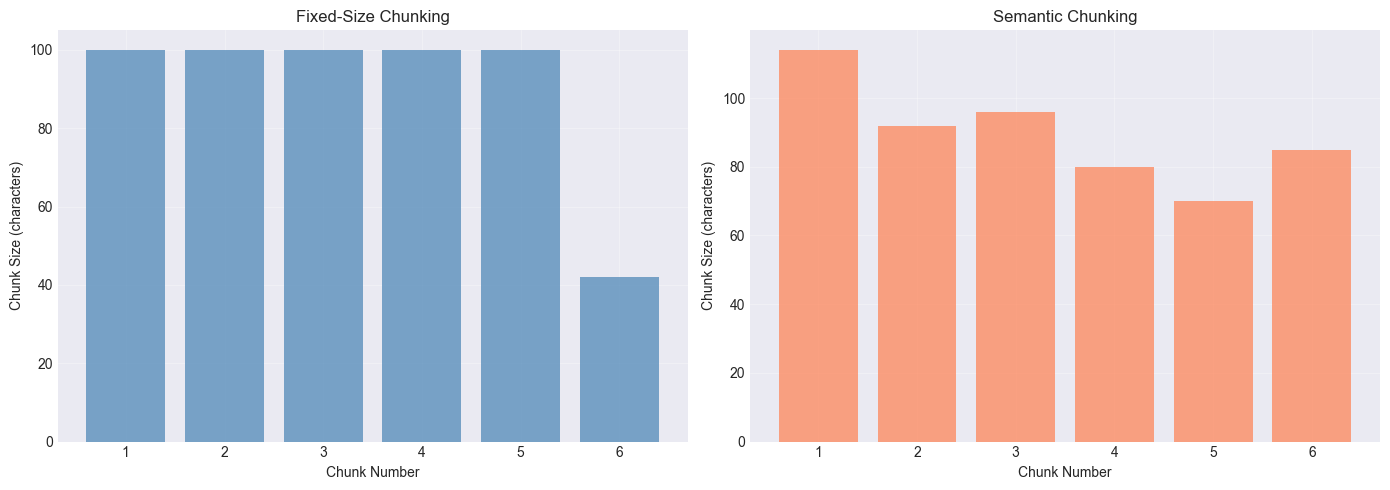


Fixed-size: 6 chunks, avg size: 90.3 chars
Semantic: 6 chunks, avg size: 89.5 chars


In [ ]:
# Visualize chunk size distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Fixed-size chunks
fixed_sizes = [len(chunk) for chunk in fixed_chunks]
ax1.bar(range(1, len(fixed_chunks) + 1), fixed_sizes, color='steelblue', alpha=0.7)
ax1.set_xlabel('Chunk Number')
ax1.set_ylabel('Chunk Size (characters)')
ax1.set_title('Fixed-Size Chunking')
ax1.grid(True, alpha=0.3)

# Semantic chunks
semantic_sizes = [len(chunk) for chunk in semantic_chunks]
ax2.bar(range(1, len(semantic_chunks) + 1), semantic_sizes, color='coral', alpha=0.7)
ax2.set_xlabel('Chunk Number')
ax2.set_ylabel('Chunk Size (characters)')
ax2.set_title('Semantic Chunking')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
img_path = images_dir / 'chunk_size_comparison.png'
plt.savefig(str(img_path), dpi=150, bbox_inches='tight')
print(f"Saved: {img_path}")
plt.show()

print(f"\nFixed-size: {len(fixed_chunks)} chunks, avg size: {np.mean(fixed_sizes):.1f} chars")
print(f"Semantic: {len(semantic_chunks)} chunks, avg size: {np.mean(semantic_sizes):.1f} chars")


In [5]:
# Setup retriever
retriever = Retriever()
retriever.index_chunks(fixed_chunks)

# Test retrieval
query = "What is machine learning?"
results = retriever.retrieve(query, k=3)
print(f"Query: '{query}'")
print(f"\nRetrieved {len(results)} chunks:")
for i, chunk in enumerate(results, 1):
    print(f"\n{i}. {chunk}")


Query: 'What is machine learning?'

Retrieved 3 chunks:

1. Machine learning is a subset of artificial intelligence that enables systems to learn and improve fr

2. age. Supervised learning uses labeled data to train models that can make predictions. Unsupervised l

3. om experience. Deep learning uses neural networks with multiple layers to process complex patterns i


## 2. Retrieval System Exploration


Saved: embedding_similarity_matrix.png


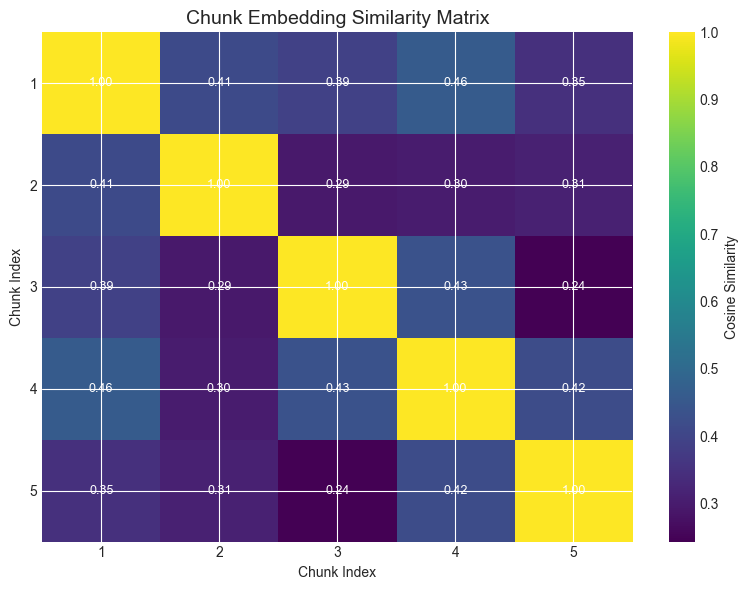

In [ ]:
# Visualize embedding similarity matrix
embedder = Embedder()
chunk_embeddings = embedder.embed(fixed_chunks[:5])  # First 5 chunks

# Calculate similarity matrix
similarity_matrix = np.dot(chunk_embeddings, chunk_embeddings.T)
norms = np.linalg.norm(chunk_embeddings, axis=1, keepdims=True)
similarity_matrix = similarity_matrix / (norms * norms.T)

plt.figure(figsize=(8, 6))
im = plt.imshow(similarity_matrix, cmap='viridis', aspect='auto')
plt.colorbar(im, label='Cosine Similarity')
plt.xlabel('Chunk Index')
plt.ylabel('Chunk Index')
plt.title('Chunk Embedding Similarity Matrix', fontsize=14)
plt.xticks(range(len(fixed_chunks[:5])), range(1, len(fixed_chunks[:5]) + 1))
plt.yticks(range(len(fixed_chunks[:5])), range(1, len(fixed_chunks[:5]) + 1))

# Add text annotations
for i in range(len(fixed_chunks[:5])):
    for j in range(len(fixed_chunks[:5])):
        text = plt.text(j, i, f'{similarity_matrix[i, j]:.2f}',
                       ha="center", va="center", color="white", fontsize=9)

plt.tight_layout()
img_path = images_dir / 'embedding_similarity_matrix.png'
plt.savefig(str(img_path), dpi=150, bbox_inches='tight')
print(f"Saved: {img_path}")
plt.show()


In [7]:
# Setup retriever
retriever = Retriever()
retriever.index_chunks(fixed_chunks)

# Test retrieval
query = "What is machine learning?"
results = retriever.retrieve(query, k=3)
print(f"Query: '{query}'")
print(f"\nRetrieved {len(results)} chunks:")
for i, chunk in enumerate(results, 1):
    print(f"\n{i}. {chunk}")


Query: 'What is machine learning?'

Retrieved 3 chunks:

1. Machine learning is a subset of artificial intelligence that enables systems to learn and improve fr

2. age. Supervised learning uses labeled data to train models that can make predictions. Unsupervised l

3. om experience. Deep learning uses neural networks with multiple layers to process complex patterns i


Saved: retrieval_scores.png


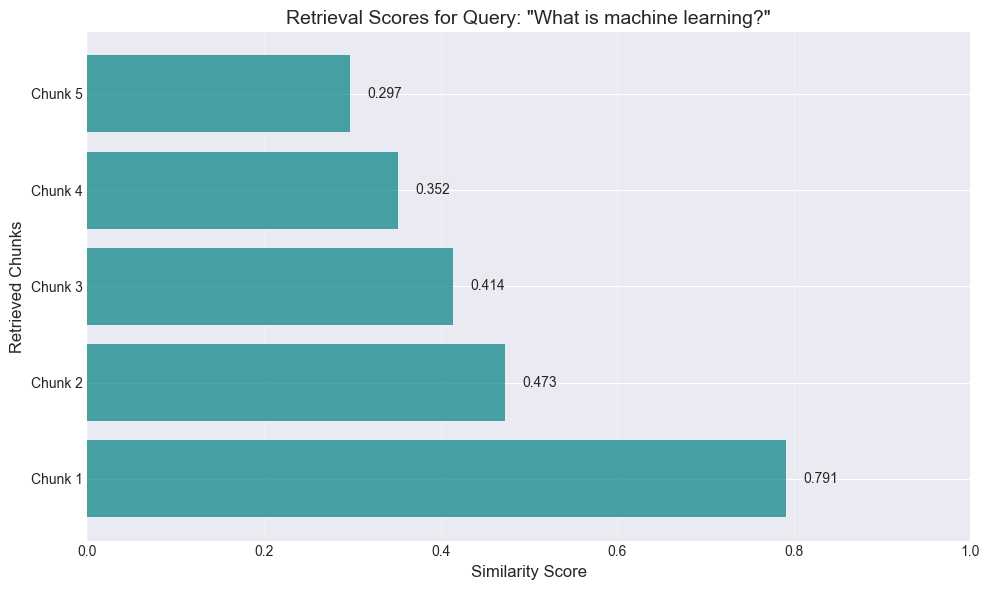


Top 5 chunks retrieved:
1. Score: 0.791 - Machine learning is a subset of artificial intelligence that...
2. Score: 0.473 - age. Supervised learning uses labeled data to train models t...
3. Score: 0.414 - om experience. Deep learning uses neural networks with multi...
4. Score: 0.352 - n data. Natural language processing handles text data and en...
5. Score: 0.297 - earning finds patterns in data without labeled examples. Rei...


In [8]:
# Retrieve with scores and visualize
scored_results = retriever.retrieve_with_scores(query, k=5)
chunks_labels = [f"Chunk {i+1}" for i in range(len(scored_results))]
scores = [score for _, score in scored_results]

plt.figure(figsize=(10, 6))
bars = plt.barh(chunks_labels, scores, color='teal', alpha=0.7)
plt.xlabel('Similarity Score', fontsize=12)
plt.ylabel('Retrieved Chunks', fontsize=12)
plt.title(f'Retrieval Scores for Query: "{query}"', fontsize=14)
plt.xlim(0, 1)
plt.grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for i, (bar, score) in enumerate(zip(bars, scores)):
    plt.text(score + 0.02, i, f'{score:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('retrieval_scores.png', dpi=150, bbox_inches='tight')
print("Saved: retrieval_scores.png")
plt.show()

print(f"\nTop {len(scored_results)} chunks retrieved:")
for i, (chunk, score) in enumerate(scored_results, 1):
    print(f"{i}. Score: {score:.3f} - {chunk[:60]}...")


## 3. Agent Interaction


In [9]:
# Setup agent
model = LocalModelClient()
worker = Worker(retriever, model)
agent = Agent(plan, worker, model)

# Test query
query = "What is deep learning?"
print(f"Query: '{query}'")
try:
    answer = agent.run(query)
    print(f"\nAnswer: {answer}")
except NotImplementedError:
    print("\n(Note: Local model not loaded - this is expected without model_name)")
    print("The agent structure is working correctly!")


Query: 'What is deep learning?'

(Note: Local model not loaded - this is expected without model_name)
The agent structure is working correctly!
